# Real or Not? NLP with Disaster Tweets
Predict which Tweets are about real disasters and which ones are not.

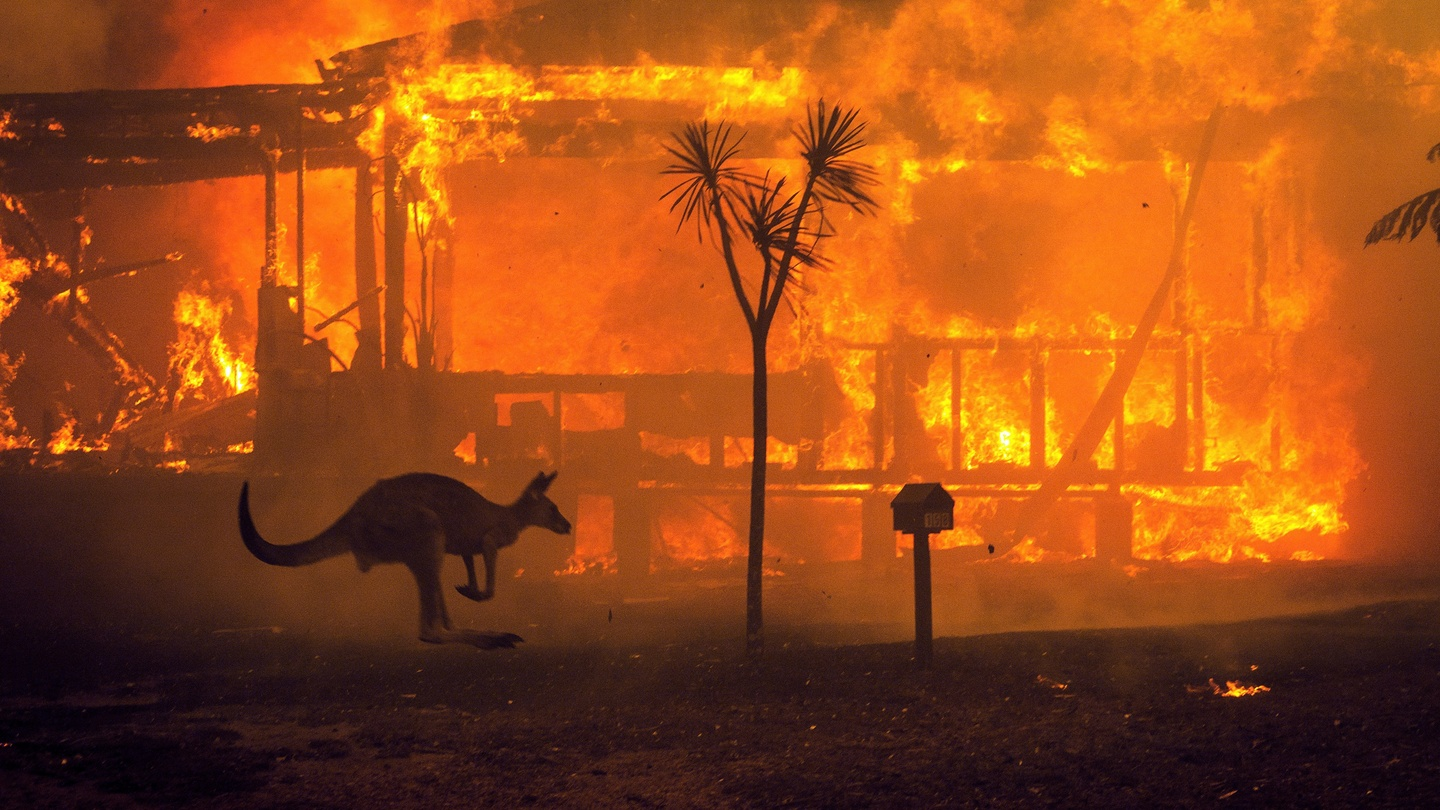

__What files do I need?__

You'll need train.csv and test.csv.

__What should I expect the data format to be?__

Each sample in the train and test set has the following information:

__The text of a tweet__

A keyword from that tweet (although this may be blank!)
The location the tweet was sent from (may also be blank)

__What am I predicting?__

You are predicting whether a given tweet is about a real disaster or not. If so, predict a 1. If not, predict a 0.

__Files__

* train.csv - the training set
* test.csv - the test set

__Columns__

* id - a unique identifier for each tweet
* text - the text of the tweet
* location - the location the tweet was sent from (may be blank)
* keyword - a particular keyword from the tweet (may be blank)
* target - in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)

## Table of Contents <a class="anchor" id="0"></a>

I.   [Import Data](#1)<br/>

II.  [Data Pre-processing for NLP with disaster tweets](#2)<br/>

   1.  [Data exploration](#2a) <br/>
   2.  [NLTK encoder](#2b)<br/>
   3.  [Tokenize with spacy](#2c)<br/>
   4.  [Create a tensorflow dataset](#2d)<br/>
   
III. [Modeling](#3)<br/>

# Import Data<a class="anchor" id="1"></a>
[return to contents](#0)

Start by installing :
1. --upgrade tensorflow
2. kaggle

In [1]:
!pip install --upgrade tensorflow
!pip install kaggle

Requirement already up-to-date: tensorflow in /usr/local/lib/python3.6/dist-packages (2.2.0rc3)


In [2]:
cd /root

/root


In [3]:
ls -al

total 68
drwx------ 1 root root 4096 Apr 26 15:02 ./
drwxr-xr-x 1 root root 4096 Apr 26 15:02 ../
-rw-r--r-- 1 root root 3106 Apr  9  2018 .bashrc
drwxr-xr-x 1 root root 4096 Apr 26 15:02 .cache/
drwxr-xr-x 1 root root 4096 Apr 23 16:41 .config/
drwxr-xr-x 3 root root 4096 Apr 23 16:11 .gsutil/
drwxr-xr-x 1 root root 4096 Apr 23 16:41 .ipython/
drwx------ 2 root root 4096 Apr 23 16:41 .jupyter/
drwxr-xr-x 2 root root 4096 Apr 26 15:02 .kaggle/
drwxr-xr-x 2 root root 4096 Apr 26 14:59 .keras/
drwx------ 1 root root 4096 Apr 23 16:41 .local/
drwxr-xr-x 3 root root 4096 Apr 23 16:41 .node-gyp/
drwxr-xr-x 4 root root 4096 Apr 23 16:41 .npm/
-rw-r--r-- 1 root root  148 Aug 17  2015 .profile


In [4]:
!pip uninstall -y kaggle
!pip install --upgrade pip
!pip install kaggle==1.5.6
!kaggle -v

Found existing installation: kaggle 1.5.6
Uninstalling kaggle-1.5.6:
  Successfully uninstalled kaggle-1.5.6
Requirement already up-to-date: pip in /usr/local/lib/python3.6/dist-packages (20.0.2)
Processing ./.cache/pip/wheels/01/3e/ff/77407ebac3ef71a79b9166a8382aecf88415a0bcbe3c095a01/kaggle-1.5.6-py3-none-any.whl
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.6/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.6/dist-packages/kaggle/api/kaggle_api_extended.py", line 149, in authenticate
    self.config_file, self.config_dir))
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [0]:
mv /kaggle.json /root/.kaggle/kaggle.json

* Use the command `!kaggle competitions download -p /content -c nlp-getting-started` to download all elements

In [6]:
!kaggle competitions download -p /content -c nlp-getting-started

  0% 0.00/593k [00:00<?, ?B/s]
100% 593k/593k [00:00<00:00, 143MB/s]


In [7]:
cd /content

/content


In [8]:
ls

nlp-getting-started.zip  sample_data/


* Using the !unzip command, unzip the files into .zip format.

In [9]:
!unzip nlp-getting-started.zip

Archive:  nlp-getting-started.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


# Data Pre-processing for NLP with disaster tweets<a class="anchor" id="2"></a>
[return to contents](#0)

In [10]:
# Import des librairies TensorFlow & Pathlib 
import tensorflow as tf 
import tensorflow_datasets as tfds
import pathlib 
import pandas as pd 
tf.__version__

'2.2.0-rc3'

In [11]:
# Import librairies 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Read_csv 
Train = pd.read_csv('train.csv', header = 0)

# Read_csv 
Test = pd.read_csv('test.csv', header = 0)

Train['text']=Train['keyword'].astype(str)+" "+Train['text'].astype(str)
Train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,nan Our Deeds are the Reason of this #earthqua...,1
1,4,NaN,NaN,nan Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,nan All residents asked to 'shelter in place' ...,1
3,6,NaN,NaN,"nan 13,000 people receive #wildfires evacuatio...",1
4,7,NaN,NaN,nan Just got sent this photo from Ruby #Alaska...,1


## Data exploration <a class="anchor" id="2a"></a>
[return to contents](#0)

In [12]:
# info on the dataset
Train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [13]:
Train.keyword.unique()

array([nan, 'ablaze', 'accident', 'aftershock', 'airplane%20accident',
       'ambulance', 'annihilated', 'annihilation', 'apocalypse',
       'armageddon', 'army', 'arson', 'arsonist', 'attack', 'attacked',
       'avalanche', 'battle', 'bioterror', 'bioterrorism', 'blaze',
       'blazing', 'bleeding', 'blew%20up', 'blight', 'blizzard', 'blood',
       'bloody', 'blown%20up', 'body%20bag', 'body%20bagging',
       'body%20bags', 'bomb', 'bombed', 'bombing', 'bridge%20collapse',
       'buildings%20burning', 'buildings%20on%20fire', 'burned',
       'burning', 'burning%20buildings', 'bush%20fires', 'casualties',
       'casualty', 'catastrophe', 'catastrophic', 'chemical%20emergency',
       'cliff%20fall', 'collapse', 'collapsed', 'collide', 'collided',
       'collision', 'crash', 'crashed', 'crush', 'crushed', 'curfew',
       'cyclone', 'damage', 'danger', 'dead', 'death', 'deaths', 'debris',
       'deluge', 'deluged', 'demolish', 'demolished', 'demolition',
       'derail', 'der

In [14]:
Train.target.value_counts()/7613

0    0.57034
1    0.42966
Name: target, dtype: float64

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


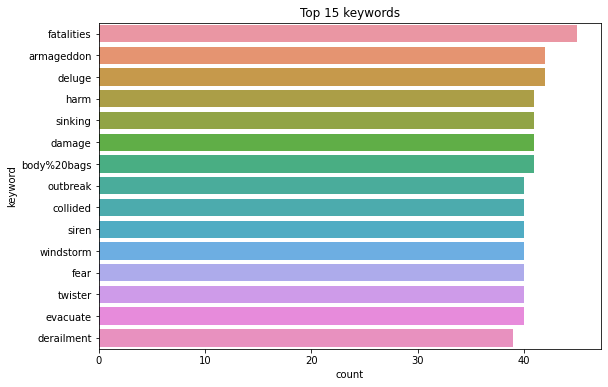

In [15]:
import seaborn as sns
plt.figure(figsize=(9,6))
sns.countplot(y=Train.keyword, order = Train.keyword.value_counts().iloc[:15].index)
plt.title('Top 15 keywords')
plt.show()

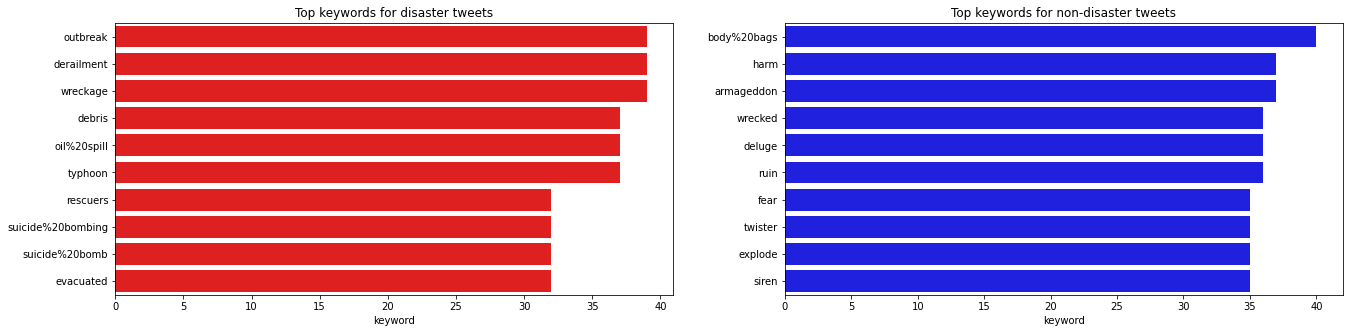

In [16]:
kw_d = Train[Train.target==1].keyword.value_counts().head(10)
kw_nd = Train[Train.target==0].keyword.value_counts().head(10)

plt.figure(figsize=(22,5))
plt.subplot(121)
sns.barplot(kw_d, kw_d.index, color='r')
plt.title('Top keywords for disaster tweets')
plt.subplot(122)
sns.barplot(kw_nd, kw_nd.index, color='b')
plt.title('Top keywords for non-disaster tweets')
plt.show()

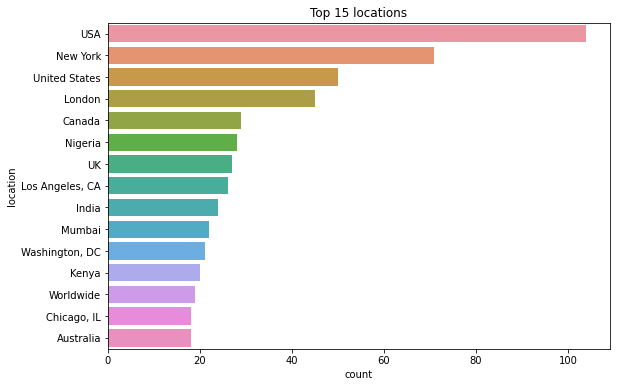

In [17]:
# Most common locations
plt.figure(figsize=(9,6))
sns.countplot(y=Train.location, order = Train.location.value_counts().iloc[:15].index)
plt.title('Top 15 locations')
plt.show()

## NLTK encoder <a class="anchor" id="2b"></a>
[return to contents](#0)

In [18]:
tweets=Train.text

len(tweets)

7613

In [19]:
# Import from librairies 
import nltk
import re
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [20]:
""" Cleaning Tweets """
def encoder_NLTK(tweets):
        tweets = tweets.str.lower()

        # removing http
        tweets = tweets.apply(lambda x : re.sub(r"http\S+","",x) )
        # removing im
        tweets = tweets.apply(lambda x : re.sub("i'm ","",x) )
        # removing im
        tweets = tweets.apply(lambda x : re.sub("nan ","",x) )
        # removing special characters and numbers
        tweets = tweets.apply(lambda x : re.sub("[^a-z\s]","",x) )

        # removing stopwords
        from nltk.corpus import stopwords
        stopwords = set(stopwords.words("english"))
        tweets = tweets.apply(lambda x : " ".join(word for word in x.split() if word not in stopwords ))
        return tweets

tweets = encoder_NLTK(tweets)
tweets.head().tolist()

['deeds reason earthquake may allah forgive us',
 'forest fire near la ronge sask canada',
 'residents asked shelter place notified officers evacuation shelter place orders expected',
 'people receive wildfires evacuation orders california',
 'got sent photo ruby alaska smoke wildfires pours school']

In [21]:
Train['tweets']= tweets.tolist()
Train.head(10)

,id,keyword,location,text,target,tweets
0,1,NaN,NaN,nan Our Deeds are the Reason of this #earthqua...,1,deeds reason earthquake may allah forgive us
1,4,NaN,NaN,nan Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,5,NaN,NaN,nan All residents asked to 'shelter in place' ...,1,residents asked shelter place notified officer...
3,6,NaN,NaN,"nan 13,000 people receive #wildfires evacuatio...",1,people receive wildfires evacuation orders cal...
4,7,NaN,NaN,nan Just got sent this photo from Ruby #Alaska...,1,got sent photo ruby alaska smoke wildfires pou...
5,8,NaN,NaN,nan #RockyFire Update => California Hwy. 20 cl...,1,rockyfire update california hwy closed directi...
6,10,NaN,NaN,nan #flood #disaster Heavy rain causes flash f...,1,flood disaster heavy rain causes flash floodin...
7,13,NaN,NaN,nan I'm on top of the hill and I can see a fir...,1,top hill see fire woods
8,14,NaN,NaN,nan There's an emergency evacuation happening ...,1,theres emergency evacuation happening building...
9,15,NaN,NaN,nan I'm afraid that the tornado is coming to o...,1,afraid tornado coming area


## Tokenize with spacy<a class="anchor" id="2c"></a>
[return to contents](#0)

We will now go through a Tokenation phase. In other words, we will assign a number to each word in our text corpus.

In [22]:
!python -m spacy download en_core_web_sm

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [0]:
# Import from Spacy and initialize to English
import en_core_web_sm
nlp = en_core_web_sm.load()

In [24]:
corpus = " ".join(tweets.to_list())
len(corpus)

562643

In [25]:
# Loading a corpus into spacy 
%%time
import time
nlp.max_length = len(corpus)

doc = nlp(corpus)


CPU times: user 10.7 s, sys: 656 ms, total: 11.4 s
Wall time: 11.4 s


In [26]:
len(doc)

77846

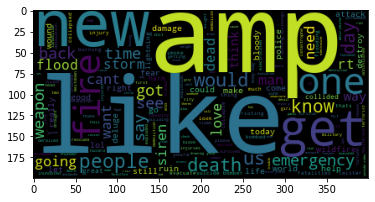

In [27]:
# Import Stop words 
from spacy.lang.fr.stop_words import STOP_WORDS
from wordcloud import WordCloud
import matplotlib.pyplot as plt
wd = WordCloud(stopwords=STOP_WORDS)
cloud = wd.generate(doc.text)
plt.imshow(cloud)

In [28]:
# Load all your tokens into a set() so you don't get any duplicates
%%time
tokens = [token.lemma_ for token in doc if token.text not in STOP_WORDS]
vocabulary_set= set(tokens)
vocab_size = len(vocabulary_set)
print(vocab_size)

14839
CPU times: user 90.5 ms, sys: 969 µs, total: 91.5 ms
Wall time: 97.3 ms


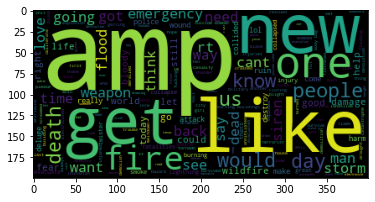

In [29]:
# Import Stop words 
from spacy.lang.fr.stop_words import STOP_WORDS
from wordcloud import WordCloud
import matplotlib.pyplot as plt
wd = WordCloud(stopwords=STOP_WORDS)
cloud = wd.generate(doc.text)
plt.imshow(cloud)

In [30]:
doc

deeds reason earthquake may allah forgive us forest fire near la ronge sask canada residents asked shelter place notified officers evacuation shelter place orders expected people receive wildfires evacuation orders california got sent photo ruby alaska smoke wildfires pours school rockyfire update california hwy closed directions due lake county fire cafire wildfires flood disaster heavy rain causes flash flooding streets manitou colorado springs areas top hill see fire woods theres emergency evacuation happening building across street afraid tornado coming area three people died heat wave far haha south tampa getting flooded hah wait second live south tampa gonna gonna fvck flooding raining flooding florida tampabay tampa days ive lost count flood bago myanmar arrived bago damage school bus multi car crash breaking whats man love fruits summer lovely car fast goooooooaaaaaal ridiculous london cool love skiing wonderful day looooool wayi cant eat shit nyc last week love girlfriend cooo

In [0]:
# Création d'un nombre pour chacun des tokens que nous avons créés au dessus
encoder = tfds.features.text.TokenTextEncoder(vocabulary_set)

In [32]:
encoder.vocab_size

14841

## Create a tensorflow dataset <a class="anchor" id="2d"></a>
[return to contents](#0)

In [0]:
# Create a tensorflow dataset in which you insert your text and target.
# NB: Your target variable & your explanatory variables must be inserted in a tuple.

In [34]:
Train.head()

,id,keyword,location,text,target,tweets
0,1,NaN,NaN,nan Our Deeds are the Reason of this #earthqua...,1,deeds reason earthquake may allah forgive us
1,4,NaN,NaN,nan Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,5,NaN,NaN,nan All residents asked to 'shelter in place' ...,1,residents asked shelter place notified officer...
3,6,NaN,NaN,"nan 13,000 people receive #wildfires evacuatio...",1,people receive wildfires evacuation orders cal...
4,7,NaN,NaN,nan Just got sent this photo from Ruby #Alaska...,1,got sent photo ruby alaska smoke wildfires pou...


In [0]:
# Creating a tf dataset from pandas 
tf_ds_train = tf.data.Dataset.from_tensor_slices((Train["tweets"].values, Train["target"].values))

In [36]:
# Let's look at an example 
for review, star in tf_ds_train.take(1):
  print(review, star)

tf.Tensor(b'deeds reason earthquake may allah forgive us', shape=(), dtype=string) tf.Tensor(1, shape=(), dtype=int64)


In [0]:
# Shuffle dataset 
tf_ds_train = tf_ds_train.shuffle(500000)

In [0]:
# Now let's encode all the elements of a dataset
def encode(text_tensor, label):
  encoded_text = encoder.encode(text_tensor.numpy())
  return encoded_text, label

# Using py_function to encode the whole dataset 
def encode_map_fn(text, label):
  return tf.py_function(encode, inp=[text, label], Tout=(tf.int64, tf.int64))

all_encoded_data = tf_ds_train.map(encode_map_fn)

In [0]:
# Train Test Split
TAKE_SIZE = int(0.8*Train.shape[0])

train_data = all_encoded_data.take(TAKE_SIZE).shuffle(50000)
train_data = train_data.padded_batch(16,  padded_shapes=([-1], []))

test_data = all_encoded_data.skip(TAKE_SIZE)
test_data = test_data.padded_batch(16, padded_shapes=([-1], []))

In [40]:
 # Let's look at a batch 
for text, label in train_data.take(1):
  print(text, label)

tf.Tensor(
[[ 9796  5455  9796 14331  8193  2955  1054 13209     0     0     0     0
      0     0     0     0]
 [ 5536  8781  5536  2697  6443 14840   608 14840  6006   956  7071  8032
      0     0     0     0]
 [10204  6151  3372  3370  7108 11212  4430 14840  6890  6151  6151  6151
      0     0     0     0]
 [ 1819  1819 14840  3766  5348  8399  7340     0     0     0     0     0
      0     0     0     0]
 [ 4345 14840 14697 13765 11147  4865 14802  1766  8216 14640 14584 14840
  14840   529     0     0]
 [13622 14840 13622 12761     0     0     0     0     0     0     0     0
      0     0     0     0]
 [ 6161  1248  8588  6567  4338  2210  5423 14840 14840 13386  9181 14840
   6161     0     0     0]
 [ 9442 14735  6294  2653  9442 14840 14840   138  3593   604 14840 14840
  14840  1637   341     0]
 [ 6081  3675  8640 12215  6081     0     0     0     0     0     0     0
      0     0     0     0]
 [ 9205   259  3093  4676  4881  7238  6144 12842 12426     0     0     0
      

In [41]:
tf.data.experimental.cardinality(train_data)

<tf.Tensor: shape=(), dtype=int64, numpy=381>

In [42]:
tf.data.experimental.cardinality(test_data)

<tf.Tensor: shape=(), dtype=int64, numpy=96>

# Modeling¶<a class="anchor" id="3"></a>
[return to contents](#0)

Let's create a model based on an LSTM layer to classify our different translations

In [0]:
model = tf.keras.Sequential([
                  # Couche d'Input Word Embedding           
                  tf.keras.layers.Embedding(encoder.vocab_size, 64),

                  # Couche LSTM Bidirectionnelle
                  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),

                  # Couche CNN
                  tf.keras.layers.Conv1D(16, 3, activation="relu"),
                  
                  # Nouvelle couche LSTM Bidirectionnel
                  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
                  # Nouvelle couche LSTM
                  tf.keras.layers.LSTM(32, return_sequences=False),               

                  # Couche Dense classique 
                  tf.keras.layers.Dense(64, activation='relu'),
                  tf.keras.layers.Dense(32, activation='relu'),
                  tf.keras.layers.Dense(16, activation='relu'),
                  tf.keras.layers.Dense(8, activation='relu'),

                  # Couche de sortie avec le nombre de neurones en sortie égale au nombre de classe avec fonction sigmoid
                  tf.keras.layers.Dense(units=1, activation='sigmoid')
])

In [44]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          949824    
_________________________________________________________________
bidirectional (Bidirectional (None, None, 128)         66048     
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          6160      
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 128)         41472     
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                20608     
_________________________________________________________________
dense (Dense)                (None, 64)                2112      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2

In [0]:
thresholds=0.50
METRICS = [
      tf.keras.metrics.TruePositives(name='tp',thresholds=thresholds),
      tf.keras.metrics.FalsePositives(name='fp',thresholds=thresholds),
      tf.keras.metrics.TrueNegatives(name='tn',thresholds=thresholds),
      tf.keras.metrics.FalseNegatives(name='fn',thresholds=thresholds),
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc')
]


In [0]:
# Création d'un schedule learning rate 
initial_learning_rate = 0.0001

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=500,
    decay_rate=0.96,
    staircase=True)

# Création d'un compileur
model.compile(optimizer = tf.keras.optimizers.Adam(lr_schedule),
              loss= tf.keras.losses.binary_crossentropy,
              metrics = [METRICS])

In [0]:
# Balance des classes
class_weight = {
    0:0.57,
    1:0.43
}

In [57]:
# Entrainement du modèle 
history = model.fit(train_data, 
                    epochs=200, 
                    validation_data=test_data,
                    class_weight=class_weight)

Epoch 1/200
381/381 [==============================] - 13s 33ms/step - loss: 0.3143 - tp: 337.0000 - fp: 121.0000 - tn: 6599.0000 - fn: 4681.0000 - accuracy: 0.5909 - precision: 0.7358 - recall: 0.0672 - auc: 0.5909 - val_loss: 0.5077 - val_tp: 418.0000 - val_fp: 59.0000 - val_tn: 802.0000 - val_fn: 244.0000 - val_accuracy: 0.8011 - val_precision: 0.8763 - val_recall: 0.6314 - val_auc: 0.8626
Epoch 2/200
381/381 [==============================] - 11s 28ms/step - loss: 0.2205 - tp: 1820.0000 - fp: 420.0000 - tn: 3052.0000 - fn: 798.0000 - accuracy: 0.8000 - precision: 0.8125 - recall: 0.6952 - auc: 0.8619 - val_loss: 0.3842 - val_tp: 538.0000 - val_fp: 69.0000 - val_tn: 749.0000 - val_fn: 167.0000 - val_accuracy: 0.8450 - val_precision: 0.8863 - val_recall: 0.7631 - val_auc: 0.9094
Epoch 3/200
381/381 [==============================] - 11s 28ms/step - loss: 0.1748 - tp: 2008.0000 - fp: 250.0000 - tn: 3216.0000 - fn: 616.0000 - accuracy: 0.8578 - precision: 0.8893 - recall: 0.7652 - auc:

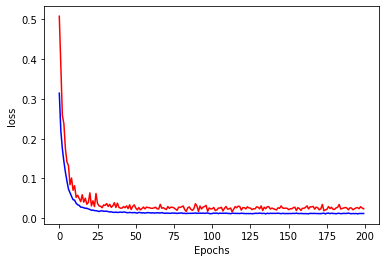

In [58]:
import matplotlib.pyplot as plt

# Visualisation du processus d'entrainement sur la loss function 
plt.plot(history.history["loss"], color="b")
plt.plot(history.history["val_loss"], color="r")
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.show()

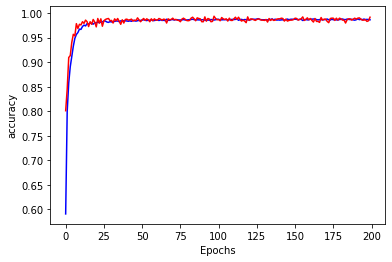

In [59]:
# Visualisation de l'entrainement sur l'accuracy 
plt.plot(history.history["accuracy"], color="b")
plt.plot(history.history["val_accuracy"], color="r")
plt.ylabel("accuracy")
plt.xlabel("Epochs")
plt.show()

In [114]:
tp=history.history['val_tp'][155]
fp=history.history['val_fp'][155]
tn=history.history['val_tn'][155]
fn=history.history['val_fn'][155]
cm= np.array([[tp,fp],[fn,tn]])
cm

array([[639.,   1.],
       [ 11., 872.]])

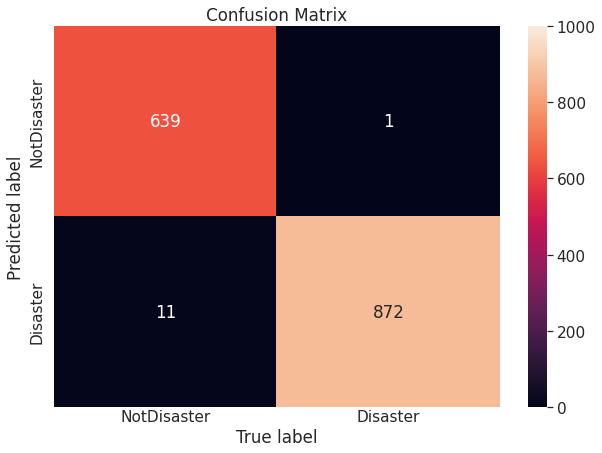

In [119]:
plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(cm, annot=True,vmin=0.0, vmax=1000.0, fmt='.0f') # font size
plt.yticks([0.5,1.5], [ 'NotDisaster', 'Disaster'],va='center')
plt.ylabel('Predicted label')
plt.xticks([0.5,1.5], [ 'NotDisaster', 'Disaster'],va='center')
plt.xlabel('True label')
plt.title("Confusion Matrix")
plt.show()

In [122]:
recall=history.history['val_recall'][155]
precision= history.history["val_precision"][155]
f1_score = (1/recall)+(1/precision)
print(2/f1_score)

0.9906976896942424
